In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [ ]:
from scipy.stats import variation


# G/day consumed data: estimate CIs. LSFF.

In [2]:
gday_path =  '/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/inputs/gday_extraction_sheet_02_22_2021.csv'
gday = pd.read_csv(gday_path)

## method b

In [9]:
# for a given vehicle v, i calculated cv=std_dev(V)/mu(V)
# then for each row, took:
    # (value_mean* cv) to approximate the std deviation of that row
    # from there i calculated 90% CIs

In [10]:
# Specific things to address/drawbacks:
# * adjusting everything to have a common denominator
# * this is using the variance of means over different countries,
#   instead of using variance data for any given location, to estimate CIs.
#   This seems like it should get incorrect results

In [3]:
## estimate CIs
gday.loc[gday.value_mean=='na','value_mean'] = np.nan
gday.value_mean = gday.value_mean.astype(float)

cv = variation(gday[(gday.vehicle=="maize flour")].value_mean)
cvs = gday[(gday.value_mean!='na') & (gday.value_mean.notna())].groupby('vehicle').value_mean.apply(variation)
cvs.name = 'coeff_var'

gday = gday.merge(cvs, on = 'vehicle')
gday['dev'] = gday.value_mean * gday.coeff_var
gday[['value_mean','dev']]

gday['lower_b'] = (gday.value_mean - (1.282)*gday.dev).clip(lower = 0) #90th percentile
gday['upper_b'] = (gday.value_mean + (1.282)*gday.dev)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


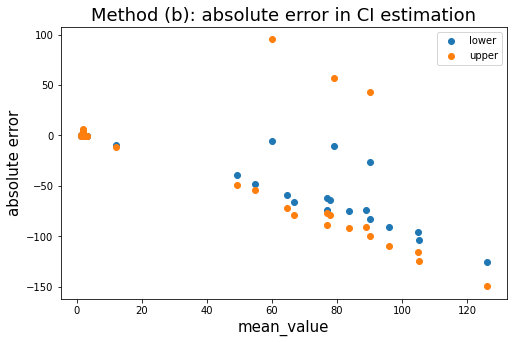

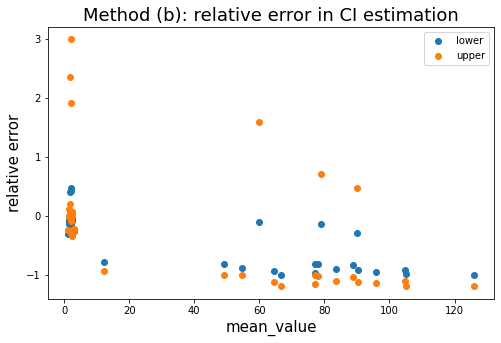

In [8]:
gday.loc[gday.value_025_percentile=='na','value_025_percentile'] = np.nan
gday.value_025_percentile = gday.value_025_percentile.astype(float)

gday.loc[gday.value_975_percentile=='na','value_975_percentile'] = np.nan
gday.value_975_percentile = gday.value_975_percentile.astype(float)

lower_error_b = gday.lower_b - gday.value_025_percentile 
upper_error_b = gday.value_975_percentile - gday.upper_b

errors = pd.DataFrame({'lower_b':lower_error_b,'upper_b':upper_error_b,'value_mean':gday.value_mean})

plt.figure(figsize=(8,5))
plt.scatter(x = errors.value_mean, y = errors.lower_b, label = 'lower')
plt.scatter(x = errors.value_mean, y = errors.upper_b, label = 'upper')

plt.xlabel('mean_value', fontsize=15)
plt.ylabel('absolute error', fontsize=15)
plt.title('Method (b): absolute error in CI estimation', fontsize=18)

plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(x = errors.value_mean, y = errors.lower_b/errors.value_mean, label = 'lower')
plt.scatter(x = errors.value_mean, y = errors.upper_b/errors.value_mean, label = 'upper')

plt.xlabel('mean_value', fontsize=15)
plt.ylabel('relative error', fontsize=15)
plt.title('Method (b): relative error in CI estimation', fontsize=18)

plt.legend()
plt.show()

## method a

In [12]:
# calculate scale_over_mean = (97.5thp - 2.5thp)/mean for all rows of data where we extracted CIs
# groupby scale_over_mean by vehicle, and take the average
# for each vehicle for which this yields an estimated spread_over_mean:
    # multiply scale_over_mean by mean_value to get an estimate of s = (97.5thp - 2.5thp)
    # calculate lower, upper = mean_value +/- s/2

In [13]:
# drawbacks:
# * we only have CIs for bouillon and wheat flour

In [14]:
gday['scale_over_mean'] = (gday.value_975_percentile - gday.value_025_percentile) / gday.value_mean

In [37]:
r = gday[['vehicle','scale_over_mean']].groupby('vehicle').mean().dropna().rename(columns={'scale_over_mean':'r'})

In [41]:
gday = gday.merge(r, on = 'vehicle', how = 'outer')
gday['lower_a'] = gday.value_mean - (gday.r * gday.value_mean)/2
gday['upper_a'] = gday.value_mean + (gday.r * gday.value_mean)/2

In [17]:
gday.groupby('vehicle').describe().scale_over_mean

,count,mean,std,min,25%,50%,75%,max
vehicle,,,,,,,,
bouillon,26.0,0.902591,1.041265,0.115385,0.290323,0.674242,0.78373,4.238095
maize flour,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rice,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wheat flour,18.0,0.666020,1.082239,0.007496,0.115722,0.255501,0.38204,3.683333
wheat(not specifically flour),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
## coefficient of variation for scale/mean
gday[gday.scale_over_mean.notna()].groupby('vehicle').scale_over_mean.apply(variation)

vehicle
bouillon       1.131236
wheat flour    1.579153
Name: scale_over_mean, dtype: float64

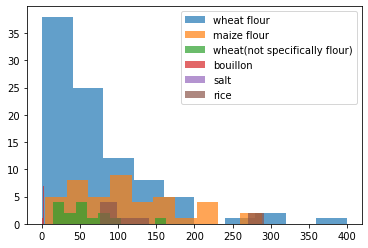

In [32]:
for v in gday.vehicle.unique():
    plt.hist(gday[gday.vehicle==v].value_mean, label = v, alpha = 0.7)
plt.legend()
plt.show()

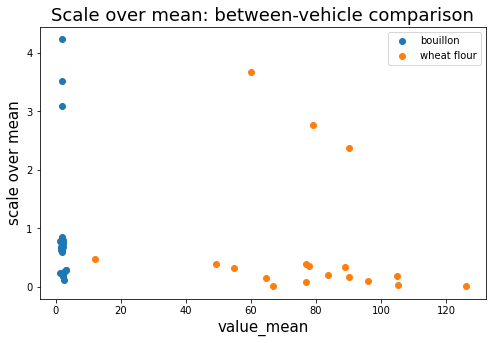

In [48]:
plt.figure(figsize=(8,5))
for v in ['bouillon','wheat flour']:
    plt.scatter(x = gday[gday.vehicle==v].value_mean, y = gday[gday.vehicle==v].scale_over_mean, label = v)

plt.title('Scale over mean: between-vehicle comparison', fontsize = 18)
plt.xlabel('value_mean', fontsize = 15)
plt.ylabel('scale over mean', fontsize = 15)
plt.legend()
plt.show()

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


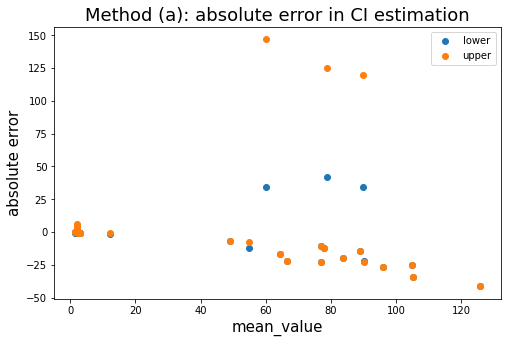

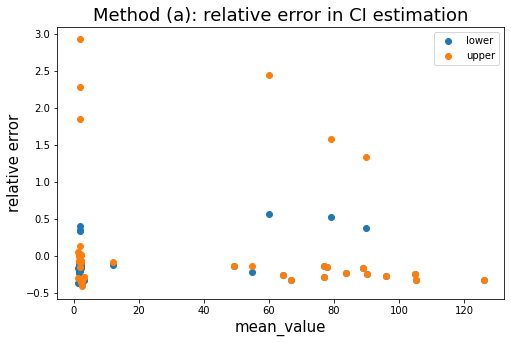

In [42]:
gday.loc[gday.value_025_percentile=='na','value_025_percentile'] = np.nan
gday.value_025_percentile = gday.value_025_percentile.astype(float)

gday.loc[gday.value_975_percentile=='na','value_975_percentile'] = np.nan
gday.value_975_percentile = gday.value_975_percentile.astype(float)

lower_error_a = gday.lower_a - gday.value_025_percentile 
upper_error_a = gday.value_975_percentile - gday.upper_a

errors = pd.DataFrame({'lower_a':lower_error_a,'upper_a':upper_error_a,'value_mean':gday.value_mean})

plt.figure(figsize=(8,5))
plt.scatter(x = errors.value_mean, y = errors.lower_a, label = 'lower')
plt.scatter(x = errors.value_mean, y = errors.upper_a, label = 'upper')

plt.xlabel('mean_value', fontsize=15)
plt.ylabel('absolute error', fontsize=15)
plt.title('Method (a): absolute error in CI estimation', fontsize=18)

plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(x = errors.value_mean, y = errors.lower_a/errors.value_mean, label = 'lower')
plt.scatter(x = errors.value_mean, y = errors.upper_a/errors.value_mean, label = 'upper')

plt.xlabel('mean_value', fontsize=15)
plt.ylabel('relative error', fontsize=15)
plt.title('Method (a): relative error in CI estimation', fontsize=18)

plt.legend()
plt.show()